<a href="https://colab.research.google.com/github/CupOfGeo/style-transfer-talk/blob/main/My_style_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HEYO! 
TODO:
- VGG 19 info / primer history of convolutions.
- Let people upload there own image and classify it with VGG19
- show filters and give exsplination
- sliders and UI for people to just upload images and style them with hyper parameters
- Github

Maybe:
- Mnist? (depending on how long that would take) 
  - show convolution and pooling layers. (Keep kernels and padding under my hat depending on crowd)

Welcome to my talk if you are just here for the pictures I'll show you that now and hopfully well have more time at the end for everytone to join in on the fun. 




How to upload and use your picture


SOURCES:
- https://www.tensorflow.org/tutorials/generative/style_transfer
- https://www.kaggle.com/learn/computer-vision

In [ ]:
#@title String fields { run: "auto", vertical-output: true, display-mode: "both" }

text = 'poop' #@param {type:"string"}
dropdown = '3rd option' #@param ["1st option", "2nd option", "3rd option"]
epochs = 500 #@param {type:"slider", min:100, max:1000, step:100}



print(epochs)

500


In [ ]:
import os
import tensorflow as tf


import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

204800/195196 [===============================] - 0s 0us/step


In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [ ]:
content_image = load_img(content_path)
style_image = load_img(style_path)

# plt.subplot(1, 2, 1)
# imshow(content_image, 'Content Image')

# plt.subplot(1, 2, 2)
# imshow(style_image, 'Style Image')

In [ ]:
'''
vgg19 without classification head
its orginially trained to do object detection
this shows how well neural nets can generalize
'''
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

#itermediate layers for style and content
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#build the model 
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255) 

In [ ]:
def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [image.shape[1] for image in images]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i][0], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

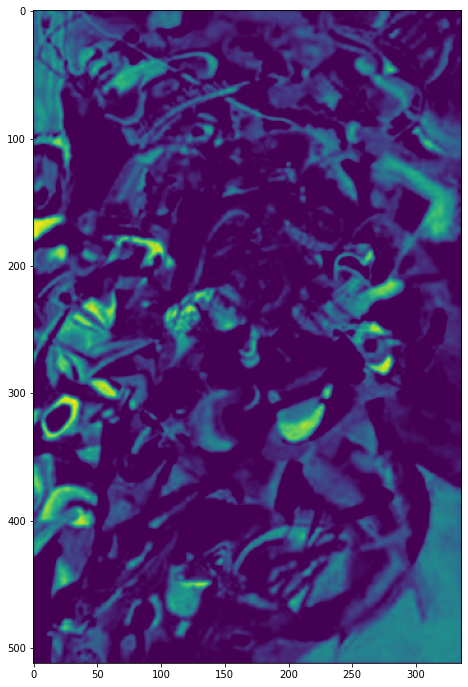

In [ ]:
style_outputs[0] #TensorShape([1, 336, 512, 64])
imshow(style_outputs[0][0,:,:,5])

filters_list = style_outputs[0][0,:,:,0:10]

swaped = np.swapaxes(filters_list,0,-1)
imshow(swaped[5])

In [ ]:
'''
The content of an image is represented by the values of the intermediate feature maps.
It turns out, the style of an image can be described by the means and correlations across the different feature maps
we use gram to get style of each layer
'''
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) #why b for layer?
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) #I*J 
  #where I is the length of F's first dim and J is legth of second dim
  return result/(num_locations)

In [ ]:
#model that returns the style and content tensors
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs] #

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)



#gradient descent
#now that we have the styles and content extracted 
#we can calc a mse for the images output relative to each target
#then take the weighted sum of these losses
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

#clip pixel values
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

# custom loss function 
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

#add regularization term on the high freq components of the image. 
#total variation loss
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_weight=30

#new loss with total_variation_weight
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

image = tf.Variable(content_image)
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  #display.clear_output(wait=True)
  #display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

....................................................................................................Train step: 100
....................................................................................................Train step: 200
....................................................................................................Train step: 300
....................................................................................................Train step: 400
....................................................................................................Train step: 500
....................................................................................................Train step: 600
....................................................................................................Train step: 700
....................................................................................................Train step: 800
........................................................................

In [ ]:
file_name = 'stylized-image40.png'
tensor_to_image(image).save(file_name)

In [ ]:
!pip install jupyter-dash

import plotly.express as px
from jupyter_dash import JupyterDash
from dash.dependencies import Input, Output, State
import dash_core_components as dcc
import dash_html_components as html
# Load Data
df = px.data.tips()
# Build App
app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1(children='THIS IS A WORK IN PROGRESS'),
    dcc.Upload(
        id='upload-image',
        children=html.Div([
            'Drag and Drop or ',
            html.A('Select Files')
        ]),
        style={
            'width': '100%',
            'height': '60px',
            'lineHeight': '60px',
            'borderWidth': '1px',
            'borderStyle': 'dashed',
            'borderRadius': '5px',
            'textAlign': 'center',
            'margin': '10px'
        },
        # Allow multiple files to be uploaded
        multiple=True
    ),
    html.Div(id='output-image-upload'),
    html.Div(children='''
    This is a Neural style transfer this is actually googles model here is the orginal paper https://arxiv.org/abs/1508.06576.
    No this is not my work i did build the serverless api call to host it. 
    I built one with VGG19 which is a large convlotion pretrained image classification network.
    ''')
])

def parse_contents(contents, filename, date):
    return html.Div([
        html.H5(filename),
        html.H6(datetime.datetime.fromtimestamp(date)),

        # HTML images accept base64 encoded strings in the same format
        # that is supplied by the upload
        html.Img(src=contents),
        html.Hr(),
        html.Div('Raw Content'),
        html.Pre(contents[0:200] + '...', style={
            'whiteSpace': 'pre-wrap',
            'wordBreak': 'break-all'
        })
    ])


@app.callback(Output('output-image-upload', 'children'),
              Input('upload-image', 'contents'),
              State('upload-image', 'filename'),
              State('upload-image', 'last_modified'))
def update_output(list_of_contents, list_of_names, list_of_dates):
    if list_of_contents is not None:
        children = [
            parse_contents(c, n, d) for c, n, d in
            zip(list_of_contents, list_of_names, list_of_dates)]
        return children


In [ ]:
app.run_server(mode='inline')